In [1]:
from functions import *

train_ft = pd.read_csv('pump_data/training_set_features.csv')
train_labels = pd.read_csv('pump_data/training_set_labels.csv')
xtrain, xtest, ytrain, ytest = train_test_split(train_ft, train_labels, random_state=17)
ytest = ytest['status_group']

# merge them for EDA purposes
df = xtrain.merge(ytrain, on='id')

# a numeric version of our target
df['status_group_numeric'] = df['status_group'].map(lambda x: 1 if x == 'functional' else -1 if x == 'non functional' else 0)

## Building a Model

After looking through the rest of the data as well and cleaning things up, we landed on the following set of features.

In [2]:
features = ['amount_tsh', 'funder', 'management', 'management_group', 'installer', 'public_meeting', 'gps_height', 'longitude', 'latitude', 'basin', 'district_code', 'permit', 'extraction_type_class', 'payment', 'quality_group', 'quantity', 'waterpoint_type_group','region', 'construction_year']

categorical_features = ['quantity', 'public_meeting', 'basin', 'permit', 'district_code', 'extraction_type_class', 'payment', 'management', 'management_group', 'quality_group', 'waterpoint_type_group', 'region', 'funder', 'installer']

numerical_features = ['amount_tsh', 'gps_height', 'longitude', 'latitude']

xtrain_ft = df[features]
ytrain = df['status_group']


Each of these features seemed to have a decent correlation with a well's functionality. Other features were excluded for being redundant (there were three separate columns each related to extraction methods) or for having too much noise (there were several hundred different subvillages). 

Our next step was to decide what kind of model to use, as well as what kind of metric to use in scoring. The terms of the competition specify accuracy as the metric, so that decision was more or less made for us. The decision regarding the kind of model to use was a little trickier.

A few options could be ruled out easily. We couldn't use Naive Bayes, for example, because our features were not independent. Similarly, a logistic regression model would be difficult to justify because there would be severe multicollinearity among our features. This left a number of other options, but after a bit of trial and error it seemed that Random Forests would be the most promising. That said, the final goal would be to combine different model types to build an ensemble model.

Our initial Random Forest model can be found below.

In [3]:
# this pipeline works on our Cleaner class, which automates many of the cleaning steps described above, and gets dummies for categorical variables
forest_pipeline = Pipeline(steps=[
    ('cleaner', Cleaner(cat_features=categorical_features)),
    ('randforest', RandomForestClassifier(),)
])

forest_pipeline.fit(xtrain_ft, ytrain)


forest_pipeline.score(xtest[features], ytest)

0.7923232323232323

79% accuracy for an untuned first pass seemed promising, especially as the winning score for the competition is 82%. Let's take a look at a confusion matrix.

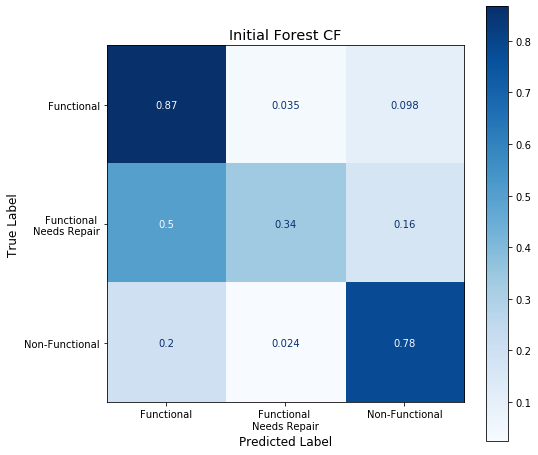

In [4]:
plot_pretty_cf(forest_pipeline, xtest[features], ytest, cmap='Blues', normalize='true', title='Initial Forest CF')

As the confusion matrix shows, our model did pretty well in labelling functional wells, a little worse with regard to non-functional wells, and quite poorly with regard to wells that need repair. This could be due to a class imbalance problem, since the 'needs repair' category represents only about 6% of the data (compare 54.6% for functional and 38.5% for non functional).

To correct this error, we try the same model but this time using SMOTE to correct for class imbalance.

In [5]:
forest_pipeline_SMOTE = Pipeline(steps=[
    ('cleaner', Cleaner(cat_features=categorical_features)),
    ('SMOTE', SMOTE()),
    ('randforest', RandomForestClassifier(),)
])

forest_pipeline_SMOTE.fit(xtrain_ft, ytrain)


forest_pipeline_SMOTE.score(xtest[features], ytest)

0.7824242424242425

Using SMOTE here actually reduced our accuracy. As the confusion matrix below shows, it did this while also not greatly improving our ability to detect when a well needed repairs. So we will not use SMOTE in our final model.

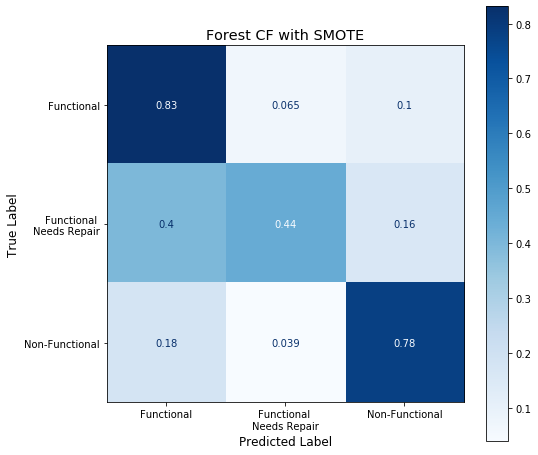

In [6]:
plot_pretty_cf(forest_pipeline_SMOTE, xtest[features], ytest, cmap='Blues', normalize='true', title='Forest CF with SMOTE')

Our next step was to try out different parameters to see if we could tune our model and improve it. For that we used a gridsearch.

In [7]:
forest_param_grid = {
    'randforest__n_estimators': [200, 250],
    'randforest__max_depth': [6, 8, None],
    'randforest__min_samples_split': [9, 10, 11],
    'randforest__min_samples_leaf': [2, 3],
    'randforest__max_features': [0.25, 0.1]
}

forest_gscv = GridSearchCV(forest_pipeline, param_grid=forest_param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

forest_gscv.fit(xtrain_ft, ytrain)

best_model = forest_gscv.best_estimator_
best_model.score(xtest[features], ytest)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 11.9min finished


0.8005387205387205

Just about 80%! Looks good. Let's get the parameters for our model. 

In [8]:
# show parameters
best_model.get_params(deep=True)

{'memory': None,
 'steps': [('cleaner',
   Cleaner(cat_features=['quantity', 'public_meeting', 'basin', 'permit',
                         'district_code', 'extraction_type_class', 'payment',
                         'management', 'management_group', 'quality_group',
                         'waterpoint_type_group', 'region', 'funder',
                         'installer'])),
  ('randforest',
   RandomForestClassifier(max_features=0.25, min_samples_leaf=2,
                          min_samples_split=9, n_estimators=200))],
 'verbose': False,
 'cleaner': Cleaner(cat_features=['quantity', 'public_meeting', 'basin', 'permit',
                       'district_code', 'extraction_type_class', 'payment',
                       'management', 'management_group', 'quality_group',
                       'waterpoint_type_group', 'region', 'funder',
                       'installer']),
 'randforest': RandomForestClassifier(max_features=0.25, min_samples_leaf=2,
                        min_samples_

One thing we can do here is check which parameters were at the upper or lower bounds of the grid search and then run another grid search with the parameters bent a bit in that direction. Here the number of estimators is at the upper limit; let's push it farther and see if we can get a better model. Other parameters seem close to the center, but let's tweak those as well. 

In [38]:
forest_param_grid2 = {
    'randforest__n_estimators': [200, 250, 300],
    'randforest__min_samples_split': [8, 9, 10],
    'randforest__min_samples_leaf': [1, 2],
    'randforest__max_features': [0.4, 0.25]
}

forest_gscv2 = GridSearchCV(forest_pipeline, param_grid=forest_param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

forest_gscv2.fit(xtrain_ft, ytrain)

best_model2 = forest_gscv.best_estimator_
best_model2.score(xtest[features], ytest)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 14.6min finished


0.8005387205387205

This score is identical to that of our last model. A look at the parameters confirms that they are the same. It was good to experiment, but the model did not want to go down the new paths we opened for it.

In [39]:
best_model2.get_params(deep=True)

{'memory': None,
 'steps': [('cleaner',
   Cleaner(cat_features=['quantity', 'public_meeting', 'basin', 'permit',
                         'district_code', 'extraction_type_class', 'payment',
                         'management', 'management_group', 'quality_group',
                         'waterpoint_type_group', 'region', 'funder',
                         'installer'])),
  ('randforest',
   RandomForestClassifier(max_features=0.25, min_samples_leaf=2,
                          min_samples_split=9, n_estimators=200))],
 'verbose': False,
 'cleaner': Cleaner(cat_features=['quantity', 'public_meeting', 'basin', 'permit',
                       'district_code', 'extraction_type_class', 'payment',
                       'management', 'management_group', 'quality_group',
                       'waterpoint_type_group', 'region', 'funder',
                       'installer']),
 'randforest': RandomForestClassifier(max_features=0.25, min_samples_leaf=2,
                        min_samples_

Let's see the confusion matrix for the model we've landed on.

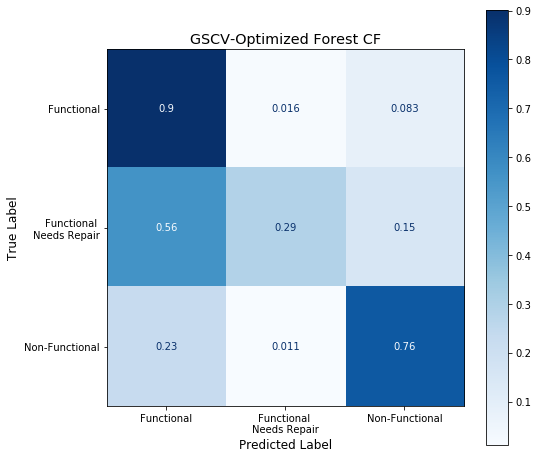

In [37]:
# pickling the model for ease of future access
model_pickle = open("pump_data/models.pkl", "wb") 
pickle.dump(best_model, model_pickle) 
model_pickle.close()

plot_pretty_cf(best_model, xtest[features], ytest, title='GSCV-Optimized Forest CF')

Perhaps surprisingly, this model does worse at detecting non-functional or repair-able wells, though it does very well at finding the functional ones. If we were more concerned about accurately discovering the non-functional wells, we may actually prefer the previous models. But given the contest's specified metric, we will stick with this one.

At this point we can actually submit our model to the competition and see how we do!

In [16]:
x_validation = pd.read_csv('pump_data/test_set_features.csv')

y_pred_validation = best_model.predict(x_validation[features])

predictions_df = pd.DataFrame(y_pred_validation, index=x_validation['id'], columns=['status_group'])

predictions_df.to_csv('pump_data/predictions3.csv')

![](images/submission_result2.png)

Woo! Not bad, well into the 80th percentile of scores. We'll take it. 

Let's take a moment to see what features are most important.

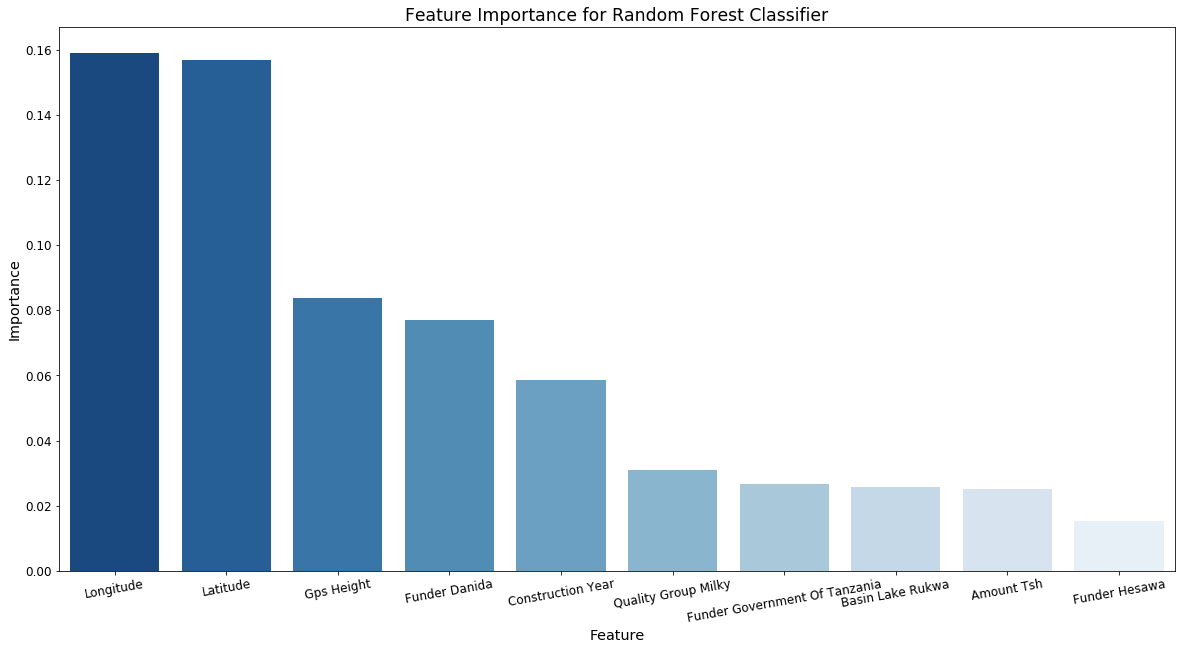

In [14]:
# make a dataframe of the features and their relative importances
feature_importances = list(forest_pipeline[1].feature_importances_)
feature_names = list(pd.get_dummies(xtrain_ft).columns)
ft_importance_df = pd.DataFrame(list(zip(feature_names, feature_importances)), columns=['Feature', 'Importance'])
ft_importance_df = ft_importance_df.sort_values('Importance', ascending=False)

# plot the top 10 features
fig, ax = plt.subplots(figsize=(20, 10))
ft_importance_df['Feature'] = ft_importance_df['Feature'].map(lambda x: x.title().replace('_', ' '))
sns.barplot(data=ft_importance_df[0:10], x='Feature', y='Importance', palette=reversed(sns.color_palette('Blues', n_colors=10)))
plt.xticks(rotation=10, fontsize='large')
plt.xlabel('Feature', fontsize='x-large')
plt.title('Feature Importance for Random Forest Classifier', fontsize='xx-large')
plt.yticks(fontsize='large')
plt.ylabel('Importance', fontsize='x-large')
plt.show()

From this we can see that it is locational features, as well as funder, extraction type, and construction year that are most predictive for our model. 

We can try another model fitting on just those features to see if we lose any accuracy.

In [11]:
# open the model
model_pickle = open('pump_data/models.pkl', 'rb')
best_model = pickle.load(model_pickle)
model_pickle.close()

best_features = ['longitude', 'latitude', 'gps_height', 'quality_group', 'construction_year', 'funder', 'extraction_type_class', 'region', 'amount_tsh', 'basin']

best_cat_features = ['extraction_type_class', 'quality_group', 'funder', 'region', 'basin']

# build a pipeline with the parameters from our best model
few_feature_pipeline= Pipeline(steps=[
    ('cleaner', Cleaner(cat_features=best_cat_features)),
    ('randforest', RandomForestClassifier(criterion='gini', n_estimators=200, max_features=0.25, min_samples_leaf=2, min_samples_split=9))
])

few_feature_pipeline.fit(xtrain[best_features], ytrain)

few_feature_pipeline.score(xtest[best_features], ytest)

0.7536700336700337

We lost about 5% accuracy, but were able to use far fewer features (only 9). Let's look at the confusion matrix.

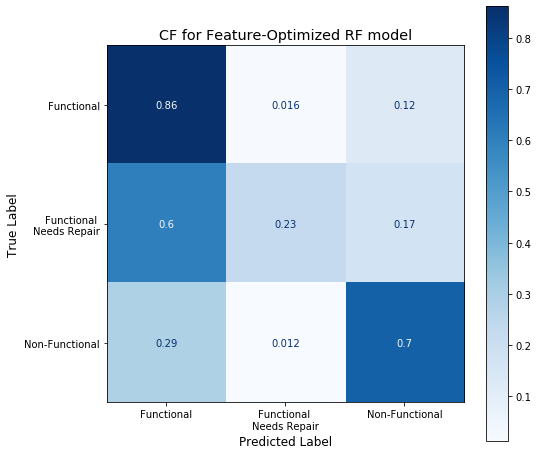

In [12]:
plot_pretty_cf(few_feature_pipeline, xtest[best_features], ytest, title='CF for Feature-Optimized RF model')

This confusion matrix shows this model performing slightly worse across the board, especially with regard to non-functional wells and those needing repair. Still, the losses are not huge. From a practical perspective, using this model might be better since it requires us to do less work researching different features of the wells.

This concludes the model-building phase. Now let's interpret the results of our final model.

## Model Interpretation

First, let's look at the top features again.

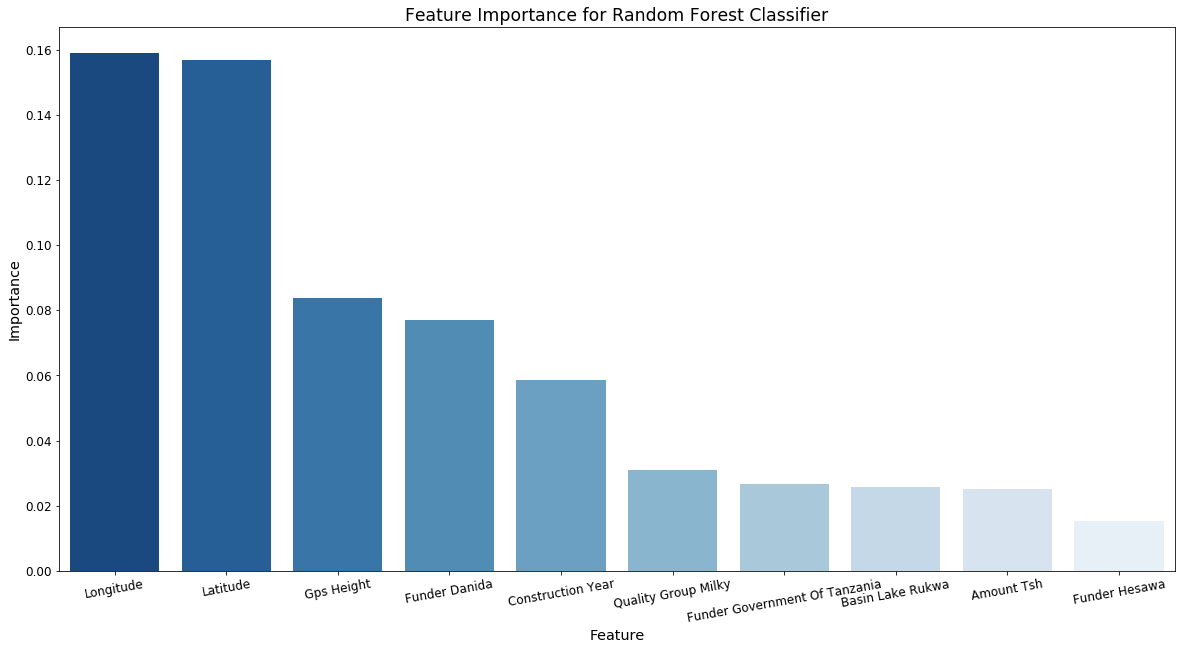

In [15]:
fig, ax = plt.subplots(figsize=(20, 10))
ft_importance_df['Feature'] = ft_importance_df['Feature'].map(lambda x: x.title().replace('_', ' '))
sns.barplot(data=ft_importance_df[0:10], x='Feature', y='Importance', palette=reversed(sns.color_palette('Blues', n_colors=10)))
plt.xticks(rotation=10, fontsize='large')
plt.xlabel('Feature', fontsize='x-large')
plt.title('Feature Importance for Random Forest Classifier', fontsize='xx-large')
plt.yticks(fontsize='large')
plt.ylabel('Importance', fontsize='x-large')
plt.show()

The primary predictive feature latitude, longitude, and altitude (gps_height). This implies that it is primarily geographic features that can predict whether a well is functional. 

This has important consequences. 
- New wells should be built in geographically suitable areas. 
- We should consider not fixing non functional wells if they are in areas that cannot adequately support them. 
- Certain regions and districts need more help with their wells than others; we can prioritize aid accordingly

Aside from the geographic features, it was features associated with the well's construction that were most impactful, primarily the water quality, the amount of static head, and the funding entity. In future we'll want to keep a close eye on water quality and intervene quickly when the quality gets bad. We can also prioritize working with certain funders like Danida and the central Government.

Our next step is to analyze the confusion matrix for our final model to determine cost. 

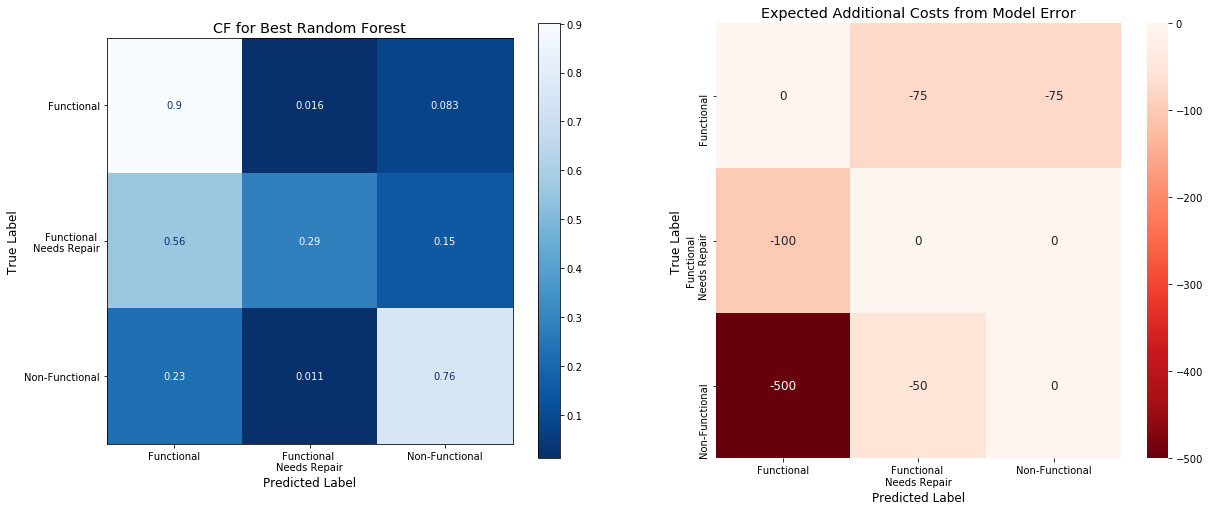

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
plot_confusion_matrix(best_model, xtest[features], ytest, ax=ax1, cmap='Blues_r', normalize='true')
ax2 = sns.heatmap(np.array([[0, -75, -75], [-100, 0,  0], [-500, -50, 0]]), cmap='Reds_r', annot=True, annot_kws={"fontsize":12}, cbar=True, fmt='g')
ax1.set_yticklabels(['Functional', 'Functional \nNeeds Repair', 'Non-Functional'])
ax1.set_xticklabels(['Functional', 'Functional \nNeeds Repair', 'Non-Functional'])
ax1.set_xlabel('Predicted Label', size='large')
ax1.set_ylabel('True Label', size='large')
ax1.set_title('CF for Best Random Forest', size='x-large')
ax2.set_yticklabels(['Functional', 'Functional \nNeeds Repair', 'Non-Functional'])
ax2.set_xticklabels(['Functional', 'Functional \nNeeds Repair', 'Non-Functional'])
ax2.set_xlabel('Predicted Label', size='large')
ax2.set_ylabel('True Label', size='large')
ax2.set_title('Expected Additional Costs from Model Error', size='x-large')
b, t = plt.ylim()
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.show() 

Here we've plotted the confusion matrix on the left and a heatmap of expected costs on the right. 

The costs were established based on estimates:
- going to repair a well that is actually functional (top row, right columns)) costs us the price of a trip to the well and a diagnostic test (75 TZS).
- failing to repair a well that is currently functioning but needs repairs (middle row, first column) costs us 100 TZS because the currently small problem can go unaddressed and lead to greater repair costs down the road. 
- classifying a non-functional well as functional (bottom row, left column) carries the greatest cost because here there will be people suffering due to lack of water. While it can be hard to quantify the economic loss from this, we have estimated it at 500 TSZ per well.
- classifying a well that is non-functional as in need of repair (bottom row, middle column) is not particularly costly. We estimate a cost of 50 TSZ. The well was to be repaired anyway, but technicians may not come with the proper tools or else will waste their time on wells that are beyond correction. We did not estimate the full 75 as above because there is a chance that the non-functional well can be repaired. Still, it is not a top priority.

Note that the cost for repairing a well that needs repair or is non-functional is listed as zero here. This is because those costs are not costs due to error but are costs we are willing to incur. We are in the business of building and maintaining wells, after all.

With this confusion matrix and the cost matrix, we can calculate the expected financial loss from our model.

In [34]:
confusion_matrix = np.array([[.9, .016, .083], [0.56, 0.29, 0.15], [0.23, 0.011, 0.76]])
cost_matrix = np.array([[0, -75, -75], [-100, 0,  0], [-500, -50, 0]])

(confusion_matrix * cost_matrix).sum()

-178.97500000000002

Our overall expected loss is about $179. Most of this comes from cases where we fail to identify non-functional wells. While technically such cases do not cost us financially (we just ignore them) they have a steep human cost and should be avoided.

Because of the parameters of the competition, we focused on accuracy as the metric for our models. From the perspective of an entity aiming to improve life in Tanzania, we might focus on recall as a better metric, since that would help build a model that errs on the side of caution when it comes to non-functional wells. 

That said, there is a case for precision in this context as well. We have limited resources and can't fix every well; perhaps it is would be best to only send technicians to wells we absolutely must fix. Since both of these metrics make sense, accuracy seems like a reasonable middle ground.

This concludes our modelling and analysis of the Tanzania well data. 

## Future Work
- try to find features that uniquely identify the wells in need of repair, since those should be our top priorities
- work to chart out the most water-starved regions. Many broken wells exist adjacent to functioning wells; when it comes to actually improving people's lives, fixing those wells is not as important as focusing on areas where there are fewer functioning wells per person.
- deal more thoroughly with data cleaning:
    - impute missing long/lat data by using data from villages, basins, etc.
    - create more macro-categories for funders, schemes, and other features with too many categories
- work on model-stacking to combine several models and hopefully increase accuracy 
    - this could be exceptionally useful if we did KNN on the geographic data, for example. 